# Predict Customers' Response to Starbucks Offer

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from time import time
import visuals as vs

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Part 1. Clean the Data

## 1. 1. Explore the three dataframes

### 1.1.1 portfolio

In [2]:
portfolio.sample(5)

,channels,difficulty,duration,id,offer_type,reward
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


In [3]:
def transform_channels(row):    
    if channel in row:
        return 1
    else:
        return 0  
    
# one hot code the 'channels' column
for channel in ['web', 'email', 'mobile', 'social']:
    portfolio[channel] = portfolio['channels'].apply(transform_channels)

# drop the original 'channels' colum    
portfolio = portfolio.drop('channels', axis =1)

# switch the column name from 'id' to 'event_id'
portfolio.columns = ['difficulty', 'duration', 'event_id', 'offer_type', 'reward', 'web', 'email', 'mobile', 'social']

In [4]:
portfolio.sample(5)

,difficulty,duration,event_id,offer_type,reward,web,email,mobile,social
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


### 1.1.2 profile

In [5]:
def transform_date(row):
    return pd.to_datetime(str(row), format = '%Y%m%d')

# convert the 'became_member_on' column from int to datetime
profile['became_member_on'] = profile['became_member_on'].apply(transform_date)

In [6]:
def calculate_member_tenure(row):
    tnow = pd.Timestamp.now()
    return pd.Timedelta(tnow - row).days

# create a column with the member tenure
profile['member_tenure'] = profile['became_member_on'].apply(calculate_member_tenure)

In [7]:
# one hot code the 'gender' column
gender = pd.get_dummies(profile['gender'], prefix = 'gender', prefix_sep = '_')

# combine the gender dataframe with profile
profile = pd.concat([profile, gender], axis = 1)

In [8]:
# drop 'became_member_on' and 'gender' columns 
profile = profile.drop(['became_member_on', 'gender'], axis = 1)
profile.sample(5)

,age,id,income,member_tenure,gender_F,gender_M,gender_O
1133,118,21a6d6b94e394809a1cc66513b60ecc7,NaN,753,0,0,0
16452,118,7f49a11dda5b44c2b6afb7d3303c2a88,NaN,834,0,0,0
16628,91,da7aced8db154427a94a9008200267e4,49000.0,2112,0,1,0
6971,118,be5cfa1a3ec24c46847b4ec8cbb039bc,NaN,1477,0,0,0
3897,51,96439f0f52704d599a1aac934118726a,50000.0,1062,1,0,0


### 1.1.3 transcript

In [9]:
transcript.sample(5)

,event,person,time,value
298378,transaction,5e4c04da5ccb48beab8b5644c14dabb2,678,{'amount': 33.6}
100951,offer completed,1bc293f211a84d2c970e085e551a1c7a,276,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
115172,offer received,6139c5f6837844ea81a3fa72fdd7152f,336,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
86751,transaction,8da164af7cdc4aa6b0fcde2e0d18284a,216,{'amount': 9.46}
105291,transaction,4e3fa85725f141f6b4bf3bae3a485986,300,{'amount': 5.5600000000000005}


In [10]:
def transform_value(row):
    if key in row:
        return row[key]
    else:
        return np.nan

# transform the 'value' column from a dictionary to two new columns with the value
for key in ['offer_id', 'offer id', 'amount']:
    transcript[key] = transcript['value'].apply(transform_value)

# convert the 'time' column from hours to days
transcript['time'] = transcript['time'] / 24

In [11]:
transcript[['offer id','offer_id']] = transcript[['offer id','offer_id']].fillna('')

# combine the 'offer id' and 'offer_id' columns
transcript['event_id'] = transcript[['offer id','offer_id']].sum(axis = 1)

# replace the '' by np.nan in event_id
transcript['event_id'].replace('', np.nan, inplace = True)

# drop the 'value','offer id', and'offer_id' column
transcript = transcript.drop(['value','offer id','offer_id'], axis = 1)

# switch the column name from 'person' to 'id'
transcript.columns = ['event', 'id', 'time','amount', 'event_id']


In [12]:
transcript.sample(5)

,event,id,time,amount,event_id
130327,offer viewed,9977ab34735945638ac018d617c90cc6,14.5,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2
131955,offer viewed,51a96d6cabd644ae905dc762588b15f8,14.5,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
118501,offer received,66cc4672d6b6417aadd7ce75c6ce7b63,14.0,NaN,2906b810c7d4411798c6938adc9daaa5
13609,offer viewed,18d309bd61ca40b8b5885c8d3d11e83a,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
19780,offer viewed,6a3c9777a6fe4dcd8271eb0a67c8b533,0.5,NaN,2906b810c7d4411798c6938adc9daaa5


## 1.2. Combine the Data

### 1.2.1 Create a dataframe to answer the question: who should receive the offer

In [13]:
# calculate the amount the number of transactions for each id
amount = transcript.groupby('id').aggregate({'amount':['sum','count']}).reset_index()
amount.columns = ['id', 'total_transaction_amount', 'number_transactions']

# merge amount with profile
profile = pd.merge(profile, amount, on = 'id')
profile.head()

,age,id,income,member_tenure,gender_F,gender_M,gender_O,total_transaction_amount,number_transactions
0,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,957,0,0,0,20.40,9
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,804,1,0,0,77.01,3
2,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,442,0,0,0,14.30,6
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,871,1,0,0,159.27,7
4,118,a03223e636434f42ac4c3df47e8bac43,NaN,784,0,0,0,4.65,3


In [14]:
transcript = pd.merge(transcript, portfolio, on = 'event_id')
transcript.head()

,event,id,time,amount,event_id,difficulty,duration,offer_type,reward,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,1,0


In [15]:
transcript.offer_type.value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [16]:
def choose_type(offer_type):
    # calculate the target 'percent_response'
    transcript_bogo = transcript[transcript.offer_type == offer_type]
    event_response_count = transcript_bogo.groupby(['id', 'event'])['event_id'].count().unstack()
    event_response_count['percent_viewed'] = event_response_count['offer viewed'] / event_response_count['offer received']
    event_response_count['percent_completed'] = event_response_count['offer completed'] / event_response_count['offer received']
    event_response_count['percent_completed'] = event_response_count['percent_completed'].fillna(0)
    event_response_count['percent_response'] = event_response_count[['percent_viewed', 'percent_completed']].min(axis = 1)
    event_response_count['target'] = event_response_count['percent_response'].apply(lambda x: 1 if x>=0.5 else 0)
    event_response_count = event_response_count.drop(['offer completed', 'offer received', 'offer viewed', 'percent_viewed', 'percent_completed', 'percent_response'], axis =1)
    return event_response_count
event_response_count = choose_type('bogo')

In [17]:
profile = pd.merge(profile, event_response_count, on = 'id')
profile.set_index('id', inplace = True)

# remove duplicates
profile = profile.drop_duplicates()

profile.head()

,age,income,member_tenure,gender_F,gender_M,gender_O,total_transaction_amount,number_transactions,target
id,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,804,1,0,0,77.01,3,1
38fe809add3b4fcf9315a9694bb96ff5,118,NaN,442,0,0,0,14.30,6,0
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,871,1,0,0,159.27,7,1
e2127556f4f64592b11af22de27a7932,68,70000.0,519,0,1,0,57.73,3,1
8ec6ce2a7e7949b1bf142def7d0e0586,118,NaN,732,0,0,0,0.00,0,0


### 1.2.2. Prepare the data for machine learning

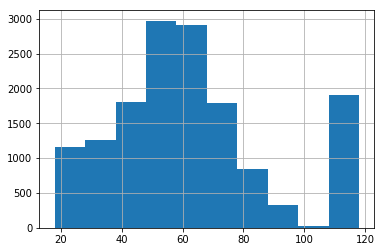

In [18]:
profile['age'].hist();

In [19]:
# replace age 118 by the median age
profile['age'].replace(118, np.nan, inplace = True)
median_age = profile['age'].median(axis = 0)
profile['age'] = profile['age'].fillna(median_age)

In [20]:
print('Percentage of null value in income:', profile.income.isnull().mean())

# replace null value of income by the median 
median_income = profile['income'].median(axis = 0)
profile['income'] = profile['income'].fillna(median_income)

Percentage of null value in income: 0.126993660327


## 1.3. Preparing the Data for the Machine Learning Model

### 1.3.1. Normalizing Numerical Features

In [21]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() 
numerical = ['age', 'income', 'member_tenure', 'total_transaction_amount', 'number_transactions']

profile[numerical] = scaler.fit_transform(profile[numerical])

# Show an example of a record with scaling applied
display(profile.head())

,age,income,member_tenure,gender_F,gender_M,gender_O,total_transaction_amount,number_transactions,target
id,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.445783,0.911111,0.206253,1,0,0,0.047871,0.083333,1
38fe809add3b4fcf9315a9694bb96ff5,0.445783,0.377778,0.007680,0,0,0,0.008889,0.166667,0
78afa995795e4d85b5d9ceeca43f5fef,0.686747,0.777778,0.243006,1,0,0,0.099006,0.194444,1
e2127556f4f64592b11af22de27a7932,0.602410,0.444444,0.049918,0,1,0,0.035886,0.083333,1
8ec6ce2a7e7949b1bf142def7d0e0586,0.445783,0.377778,0.166758,0,0,0,0.000000,0.000000,0


### 1.3.2. Shuffle and Split Data

In [22]:
X = profile.drop('target', axis = 1)
y = profile['target']

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 11988 samples.
Testing set has 2997 samples.


# Part 2. Evaluating Model Performance

## 2.1. Naive Predictor Performace

The naive predictor is that we predict that everyone has the percent_reponse above or equal to 0.5.

In [23]:
n_records = profile.shape[0]
n_1 = profile[profile.target == 1].shape[0]

In [24]:
# Calculate accuracy, precision and recall
accuracy = n_1 / n_records
recall = 1
precision = n_1 / n_records

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2)*(recall * precision)/(0.5**2*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5591, F-score: 0.6132]


## 2.2. Supervised Learning Models

### 2.2.1. Creating a Training and Predicting Pipeline

In [25]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end -start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # alculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = f1_score(y_train[:300], predictions_train)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = f1_score(y_test, predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### 2.2.2. Initial Model Evaluation

LogisticRegression trained on 119 samples.
LogisticRegression trained on 1198 samples.
LogisticRegression trained on 11988 samples.
RandomForestClassifier trained on 119 samples.
RandomForestClassifier trained on 1198 samples.
RandomForestClassifier trained on 11988 samples.
AdaBoostClassifier trained on 119 samples.
AdaBoostClassifier trained on 1198 samples.
AdaBoostClassifier trained on 11988 samples.


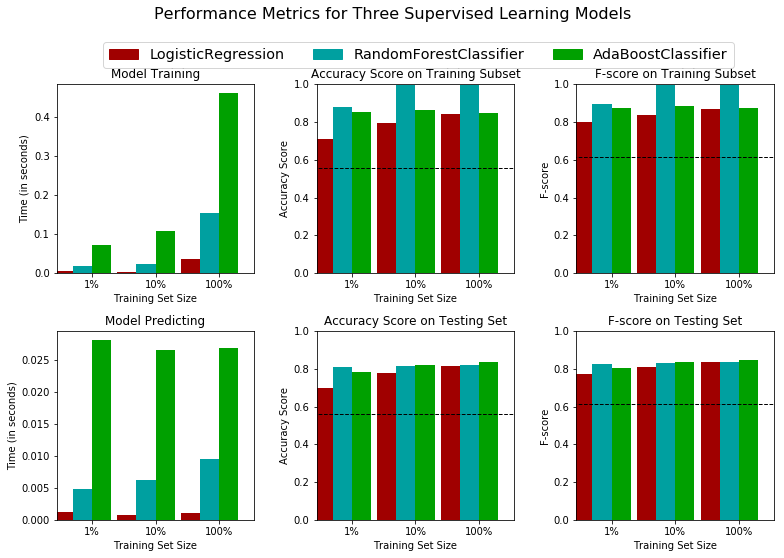

In [26]:
# Initialize three models
clf_A = LogisticRegression(random_state = 1, solver = 'liblinear')
clf_B = RandomForestClassifier(random_state = 1, n_estimators = 10)
clf_C = AdaBoostClassifier(random_state = 1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(samples_100 *0.1)
samples_1 = int(samples_100 *0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### 2.2.3. Model Tuning

In [27]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from time import time
import visuals as vs

start = time()
# Initialize the classifier
clf = RandomForestClassifier(random_state = 1)

# Create hyperparameter options
parameters = {'n_estimators': [50, 100, 150],
              'min_samples_leaf': [2, 4, 6], 
              'min_samples_split': [5, 10, 15], 
              'max_depth': [10, 20, 30]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf, param_grid = parameters, scoring = scorer, cv = 3)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

end = time()

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))
print(f"Time in seconds: {end-start}")

Unoptimized model
------
Accuracy score on testing data: 0.8195
F-score on testing data: 0.8342

Optimized Model
------
Final accuracy score on the testing data: 0.8395
Final F-score on the testing data: 0.8542
Time in seconds: 249.9463653564453


In [28]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [29]:
# from joblib import dump, load
# dump(best_clf, 'best_clf.joblib') 
# clf = load('best_clf.joblib') 

# Part 3. Discussion

In this project, I first explored, cleaned and combined the data. I generated a function choose_type which allows users to choose the offer types (bogo, discount or informational). Then I built several supervised learning models to predict whether to extend that offer type to a customer based on the demographic and transaction data. I used accuracy and f1 scores to evaluate the performance. I also considered the performance of the naive evaluator, which predicted that we should give offers to everyone. I chose Random Forest as the learner because it is a good balance between performance and running time. Lastly, I used grid search to tune the model. The optimized model has the accuracy of 0.83 and the f1 score of 0.85. 

To summarize, I built a model that predicts customers' response to an offer, utilizing Random Forest Classifiers. Specifically, the user of this model could choose an offer type, and identify the customers who are the ideal targets of the offer. 